## Using embeddings trained from stack overflow data
[source](https://github.com/vefstathiou/SO_word2vec)

In [19]:
%run "Models training helpers.ipynb" sort=False

Models training helpers.ipynb:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  "\n",


In [62]:
# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set() 
sns.set_style("whitegrid")

In [20]:
from gensim.models.keyedvectors import KeyedVectors
SO_embeddings = KeyedVectors.load_word2vec_format("Data/SO_vectors_200.bin", binary=True)

In [21]:
SO_embeddings.similarity('computer', 'pc')

0.86835635

In [22]:
'computer' in SO_embeddings

True

In [57]:
CONVENTION = "Industrial"
CONVENTION_LOWER = CONVENTION.lower()
EMBEDDING_DIM_SO=200
NUM_EPOCHS=20

In [24]:
training_df = read_training_data()
df = training_df[training_df['convention'] == CONVENTION]

In [25]:
### Ading more green examples
green_audit_df = pd.read_csv("Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL_2019-10-08-20:23:58.598102.tsv", sep="\t")
green_audit_df = green_audit_df[['text', 'provenance', 'convention', 'new']]
green_audit_df = green_audit_df.rename(columns={"new": "label"})
green_audit_df = green_audit_df[green_audit_df['convention']==CONVENTION_LOWER]
green_audit_df['convention'] = CONVENTION
green_audit_df.head(5)

,text,provenance,convention,label
0,The parser generates events similar to an xml ...,efficiency,Industrial,1
1,Verify response time of the Application Under ...,efficiency,Industrial,1
2,"Flexible and powerful JSON manipulation, valid...",efficiency,Industrial,1
3,"Requires data to be entered only once, with no...",efficiency,Industrial,1
4,DebugBear - Monitor website performance and Li...,efficiency,Industrial,1


In [26]:
df = pd.concat([df, green_audit_df])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [27]:
## Training a deep learning model given training, validation data
def train_DL_model_SO(x_train, y_train, x_val, y_val, tokenizer, num_epochs=NUM_EPOCHS):
    
    word_index = tokenizer.word_index
    
    print('\nNumber of elements from each class in traing and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))


    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM_SO))
    for word, i in word_index.items():
        if word in SO_embeddings:
            
            embedding_vector = SO_embeddings[word]#embeddings_index.get(word)
        else:
            embedding_vector = None
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM_SO,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    

    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#
    
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)

    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)
    """
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)

    l_flat = Flatten()(l_cov2)
    
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')
    """
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    
    print("model fitting - more complex convolutional neural network")
    model.summary()
    train_history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=num_epochs, batch_size=50, callbacks=[roc_callback(validation_data=(x_val, y_val))])

    return model,tokenizer,x_val,y_val, train_history

In [29]:
## Trains one DL model for each group of sentences (within each convention)
def train_DL_models_SO(df_train,
                    data_class_column="convention", 
                    data_label_column="label",
                   df_val=None,
                    tokenizer=None,
                   random_seed=None,
                   use_validation=True, num_epochs = NUM_EPOCHS):
    
    
    _models = {}
    _tokenizers = {}
    _data_val_x = {}
    _data_val_y = {}
    _train_histories = {}
    if tokenizer is None:        
        if df_val is None:
            tokenizer = create_tokenizer(df_train)
        else:
            tokenizer = create_tokenizer(pd.concat([df_train, df_val]))

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    
    for convention in df[data_class_column].unique():
        
        print("----------------------------------------------------------------")
        print("            {}                  ".format(convention))
        print("----------------------------------------------------------------")
        
        tmp_df_train = df_train[df_train[data_class_column] == convention]
        if use_validation:
            if df_val is None:

                texts = tmp_df_train['text'].values
                labels = tmp_df_train[data_label_column].values

                sequences = tokenizer.texts_to_sequences(texts)


                data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

                labels = to_categorical(np.asarray(labels))
                print('Shape of data tensor:', data.shape)
                print('Shape of label tensor:', labels.shape)

                indices = np.arange(data.shape[0])
                if random_seed is not None:
                    np.random.seed(random_seed)
                np.random.shuffle(indices)
                data = data[indices]
                labels = labels[indices]
                nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])



                x_train = data[:-nb_validation_samples]
                y_train = labels[:-nb_validation_samples]
                x_val = data[-nb_validation_samples:]
                y_val = labels[-nb_validation_samples:]


                _model, _tokenizer, _x_val, _y_val, _train_h = train_DL_model_SO(x_train, y_train, x_val, y_val, tokenizer, num_epochs=num_epochs)
            else:

                tmp_df_val = df_val[df_val[data_class_column] == convention]

                train_texts = tmp_df_train['text'].values
                train_labels = tmp_df_train[data_label_column].values

                val_texts = tmp_df_val['text'].values
                val_labels = tmp_df_val[data_label_column].values

                train_sequences = tokenizer.texts_to_sequences(train_texts)
                val_sequences = tokenizer.texts_to_sequences(val_texts)



                x_train = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
                x_val = pad_sequences(val_sequences, maxlen=MAX_SEQUENCE_LENGTH)

                y_train = to_categorical(np.asarray(train_labels))
                y_val = to_categorical(np.asarray(val_labels))

                _model, _tokenizer, _x_val, _y_val, _train_h = train_DL_model_SO(x_train, y_train, x_val, y_val, tokenizer, num_epochs=num_epochs)
        
            _models[convention] = _model
            _tokenizers[convention] = _tokenizer
            _data_val_x[convention] = _x_val
            _data_val_y[convention] = _y_val
            _train_histories[convention] = _train_h
        
    return (_models, _tokenizers, _data_val_x, _data_val_y, _train_histories)

In [54]:
conv_models = train_DL_models_SO(df)

Found 5480 unique tokens.
----------------------------------------------------------------
            Industrial                  
----------------------------------------------------------------
Shape of data tensor: (1812, 40)
Shape of label tensor: (1812, 2)

Number of elements from each class in traing and validation set 
[913. 537.]
[228. 134.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_52"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 40, 200)      1096200     input_52[0][0]                   
__________________________________________________________________________________________________
conv1d_205 (Conv1D)             (None, 38, 128)      76928       embedding_52[0][0]               
__________________________________________________________________________________________________
conv1d_206 (Conv1D)             (None, 37, 128)      102528      embedding_52[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


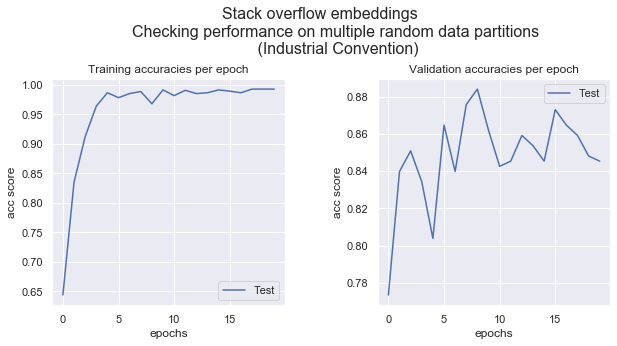

In [55]:
accs = conv_models[4][CONVENTION].history['acc']
val_accs = conv_models[4][CONVENTION].history['val_acc']

epochs=np.arange(0,NUM_EPOCHS,1)

fig = plt.figure(figsize=[10,10])
fig.suptitle("Stack overflow embeddings \n      Checking performance on multiple random data partitions\n       ({} Convention)".format(CONVENTION), fontsize=16)
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)


plt.plot(epochs,accs, label="Test")
plt.title("Training accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()

plt.subplot(2, 2, 2)

plt.plot(epochs,val_accs, label="Test")
plt.title("Validation accuracies per epoch")
plt.xlabel("epochs")
plt.ylabel("acc score")
plt.legend()
plt.show()


In [53]:
val_accs

[0.6187845261057437,
 0.8480662953787745,
 0.8646408816727486,
 0.8591160188063732,
 0.8618784451352958,
 0.8784530169397428,
 0.8729281685628943,
 0.8895027548568684,
 0.8867403222711047,
 0.8701657320254416,
 0.7099447589552863,
 0.8729281603302086,
 0.8839778982473342,
 0.8729281685628943,
 0.8756905968676615,
 0.8756906090520363,
 0.8839778939663376,
 0.8839778982473342,
 0.8867403183194155,
 0.8867403183194155]

In [56]:
NUM_SENTENCES_TO_SHOW=20

df_test = pd.read_csv(os.path.join(GATHERED_DATA_FOLDER, "gathered_github_sentences.tsv"), sep="\t")

test_sentences = df_test['sentence'].values
test_sentences = np.array([sent for sent in test_sentences if len(sent.split(" "))<40])

test_seq = extended_tokenizer.texts_to_sequences(test_sentences)
test_seq = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)

preds = conv_models[0][CONVENTION].predict(test_seq)[:,1]

print("-----------------------------------------------------")
print(" >> DL model results")
print(" >> Top sentences with higher confidence for Github:")
print("            ({} convention)".format(CONVENTION))
print("-----------------------------------------------------\n")
for s in test_sentences[preds.argsort()[-NUM_SENTENCES_TO_SHOW:][::-1]]:
    print("{}\n".format(s))

InvalidArgumentError: indices[15,39] = 7029 is not in [0, 5481)
	 [[{{node embedding_52/embedding_lookup}}]]

## Testing performance with different word embeddings

In [60]:
conventions = ["Industrial", "Green"]
N = 5
## Execute comparison
val_accsGlove = {}
val_accsSO = {}

for c in conventions:
    
    training_df = read_training_data()
    df = training_df[training_df['convention'] == c]

    ### Ading more green examples
    green_audit_df = pd.read_csv("Data/Iterative-models-building/Classification results/Conventions/Audited/audited_ALL_2019-10-08-20:23:58.598102.tsv", sep="\t")
    green_audit_df = green_audit_df[['text', 'provenance', 'convention', 'new']]
    green_audit_df = green_audit_df.rename(columns={"new": "label"})
    green_audit_df = green_audit_df[green_audit_df['convention']==c.lower()]
    green_audit_df['convention'] = CONVENTION
    green_audit_df.head(5)

    df = pd.concat([df, green_audit_df])

    
    for n in range(N):

        print("\n\n=================================")
        print("               {}-{}".format(c, n))
        print("=================================")
        
        texts = df['text'].values
        labels = df['label'].values

        sequences = extended_tokenizer.texts_to_sequences(texts)


        data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

        labels = to_categorical(np.asarray(labels))
        print('Shape of data tensor:', data.shape)
        print('Shape of label tensor:', labels.shape)

        indices = np.arange(data.shape[0])
    
        np.random.shuffle(indices)
        data = data[indices]
        labels = labels[indices]
        nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])



        x_train = data[:-nb_validation_samples]
        y_train = labels[:-nb_validation_samples]
        x_val = data[-nb_validation_samples:]
        y_val = labels[-nb_validation_samples:]

        print("               {}-{} Glove".format(c, n))
        modelGlove,tokenizerGlove,x_valGlove,y_valGlove, train_historyGlove = train_DL_model(x_train, y_train, x_val, y_val, extended_tokenizer)
        print("               {}-{} SO".format(c, n))
        modelSO,tokenizerSO,x_valSO,y_valSO, train_historySO = train_DL_model_SO(x_train, y_train, x_val, y_val, extended_tokenizer)
        
        if c in val_accsSO:
            val_accsSO[c].append(train_historySO.history['val_acc'][-1])
            val_accsGlove[c].append(train_historyGlove.history['val_acc'][-1])
        else:
            val_accsSO[c] = [train_historySO.history['val_acc'][-1]]
            val_accsGlove[c] = [train_historyGlove.history['val_acc'][-1]]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.





               Industrial-0
Shape of data tensor: (1812, 40)
Shape of label tensor: (1812, 2)
               Industrial-0 Glove

Number of elements from each class in traing and validation set 
[914. 536.]
[227. 135.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_64"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_64 (Embedding)        (None, 40, 100)      8269200     input_64[0][0]                   
__________________________________________________________________________________________________
conv1d_253 (Conv1D)             (None, 38, 128)      38528       embedding_64[0][0]               
__________________________________________________________________________________________________
conv1d_254 (Conv1D)             (None, 37, 128)      51328       embedding_64[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 40, 200)      16538400    input_65[0][0]                   
__________________________________________________________________________________________________
conv1d_257 (Conv1D)             (None, 38, 128)      76928       embedding_65[0][0]               
__________________________________________________________________________________________________
conv1d_258 (Conv1D)             (None, 37, 128)      102528      embedding_65[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_66 (Embedding)        (None, 40, 100)      8269200     input_66[0][0]                   
__________________________________________________________________________________________________
conv1d_261 (Conv1D)             (None, 38, 128)      38528       embedding_66[0][0]               
__________________________________________________________________________________________________
conv1d_262 (Conv1D)             (None, 37, 128)      51328       embedding_66[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 40, 200)      16538400    input_67[0][0]                   
__________________________________________________________________________________________________
conv1d_265 (Conv1D)             (None, 38, 128)      76928       embedding_67[0][0]               
__________________________________________________________________________________________________
conv1d_266 (Conv1D)             (None, 37, 128)      102528      embedding_67[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_68"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_68 (Embedding)        (None, 40, 100)      8269200     input_68[0][0]                   
__________________________________________________________________________________________________
conv1d_269 (Conv1D)             (None, 38, 128)      38528       embedding_68[0][0]               
__________________________________________________________________________________________________
conv1d_270 (Conv1D)             (None, 37, 128)      51328       embedding_68[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_69 (Embedding)        (None, 40, 200)      16538400    input_69[0][0]                   
__________________________________________________________________________________________________
conv1d_273 (Conv1D)             (None, 38, 128)      76928       embedding_69[0][0]               
__________________________________________________________________________________________________
conv1d_274 (Conv1D)             (None, 37, 128)      102528      embedding_69[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_70"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_70 (Embedding)        (None, 40, 100)      8269200     input_70[0][0]                   
__________________________________________________________________________________________________
conv1d_277 (Conv1D)             (None, 38, 128)      38528       embedding_70[0][0]               
__________________________________________________________________________________________________
conv1d_278 (Conv1D)             (None, 37, 128)      51328       embedding_70[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 40, 200)      16538400    input_71[0][0]                   
__________________________________________________________________________________________________
conv1d_281 (Conv1D)             (None, 38, 128)      76928       embedding_71[0][0]               
__________________________________________________________________________________________________
conv1d_282 (Conv1D)             (None, 37, 128)      102528      embedding_71[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_72"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_72 (Embedding)        (None, 40, 100)      8269200     input_72[0][0]                   
__________________________________________________________________________________________________
conv1d_285 (Conv1D)             (None, 38, 128)      38528       embedding_72[0][0]               
__________________________________________________________________________________________________
conv1d_286 (Conv1D)             (None, 37, 128)      51328       embedding_72[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_73 (Embedding)        (None, 40, 200)      16538400    input_73[0][0]                   
__________________________________________________________________________________________________
conv1d_289 (Conv1D)             (None, 38, 128)      76928       embedding_73[0][0]               
__________________________________________________________________________________________________
conv1d_290 (Conv1D)             (None, 37, 128)      102528      embedding_73[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_74"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_74 (Embedding)        (None, 40, 100)      8269200     input_74[0][0]                   
__________________________________________________________________________________________________
conv1d_293 (Conv1D)             (None, 38, 128)      38528       embedding_74[0][0]               
__________________________________________________________________________________________________
conv1d_294 (Conv1D)             (None, 37, 128)      51328       embedding_74[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_75 (Embedding)        (None, 40, 200)      16538400    input_75[0][0]                   
__________________________________________________________________________________________________
conv1d_297 (Conv1D)             (None, 38, 128)      76928       embedding_75[0][0]               
__________________________________________________________________________________________________
conv1d_298 (Conv1D)             (None, 37, 128)      102528      embedding_75[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_76"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_76 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 40, 100)      8269200     input_76[0][0]                   
__________________________________________________________________________________________________
conv1d_301 (Conv1D)             (None, 38, 128)      38528       embedding_76[0][0]               
__________________________________________________________________________________________________
conv1d_302 (Conv1D)             (None, 37, 128)      51328       embedding_76[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_77 (Embedding)        (None, 40, 200)      16538400    input_77[0][0]                   
__________________________________________________________________________________________________
conv1d_305 (Conv1D)             (None, 38, 128)      76928       embedding_77[0][0]               
__________________________________________________________________________________________________
conv1d_306 (Conv1D)             (None, 37, 128)      102528      embedding_77[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_78"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_78 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_78 (Embedding)        (None, 40, 100)      8269200     input_78[0][0]                   
__________________________________________________________________________________________________
conv1d_309 (Conv1D)             (None, 38, 128)      38528       embedding_78[0][0]               
__________________________________________________________________________________________________
conv1d_310 (Conv1D)             (None, 37, 128)      51328       embedding_78[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_79 (Embedding)        (None, 40, 200)      16538400    input_79[0][0]                   
__________________________________________________________________________________________________
conv1d_313 (Conv1D)             (None, 38, 128)      76928       embedding_79[0][0]               
__________________________________________________________________________________________________
conv1d_314 (Conv1D)             (None, 37, 128)      102528      embedding_79[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_80"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 40, 100)      8269200     input_80[0][0]                   
__________________________________________________________________________________________________
conv1d_317 (Conv1D)             (None, 38, 128)      38528       embedding_80[0][0]               
__________________________________________________________________________________________________
conv1d_318 (Conv1D)             (None, 37, 128)      51328       embedding_80[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_81 (Embedding)        (None, 40, 200)      16538400    input_81[0][0]                   
__________________________________________________________________________________________________
conv1d_321 (Conv1D)             (None, 38, 128)      76928       embedding_81[0][0]               
__________________________________________________________________________________________________
conv1d_322 (Conv1D)             (None, 37, 128)      102528      embedding_81[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_82 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_82 (Embedding)        (None, 40, 100)      8269200     input_82[0][0]                   
__________________________________________________________________________________________________
conv1d_325 (Conv1D)             (None, 38, 128)      38528       embedding_82[0][0]               
__________________________________________________________________________________________________
conv1d_326 (Conv1D)             (None, 37, 128)      51328       embedding_82[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
Model: "model_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_83 (Embedding)        (None, 40, 200)      16538400    input_83[0][0]                   
__________________________________________________________________________________________________
conv1d_329 (Conv1D)             (None, 38, 128)      76928       embedding_83[0][0]               
__________________________________________________________________________________________________
conv1d_330 (Conv1D)             (None, 37, 128)      102528      embedding_83[0][0]               
_________________________________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


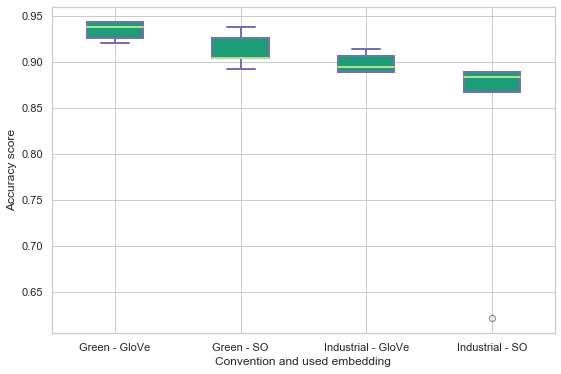

In [64]:
## numpy is used for creating fake data
import numpy as np 
import matplotlib as mpl 

## agg backend is used to create plot as a .png file
mpl.use('agg')

import matplotlib.pyplot as plt 


## Create data
np.random.seed(10)
collectn_1 = val_accsGlove['Green']
collectn_2 = val_accsSO['Green']
collectn_3 = val_accsGlove['Industrial']
collectn_4 = val_accsSO['Industrial']

## combine these different collections into a list    
data_to_plot = [collectn_1, collectn_2, collectn_3, collectn_4]


# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)


## add patch_artist=True option to ax.boxplot() 
## to get fill color
bp = ax.boxplot(data_to_plot, patch_artist=True)

## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#7570b3', linewidth=2)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#b2df8a', linewidth=2)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    
## Custom x-axis labels
ax.set_xticklabels(['Green - GloVe', 'Green - SO', 'Industrial - GloVe', 'Industrial - SO'])

plt.ylabel("Accuracy score")
plt.xlabel("Convention and used embedding")

# Save the figure
plt.show()

In [ ]:
val_accsGlove['Industrial']

In [ ]:
val_accsSO['Industrial']